# 02 - Model Development and Hyperparameter Tuning

This notebook trains all required models, performs tuning for Random Forest and XGBoost, tracks experiments with MLflow, and saves model artifacts.

In [21]:
import warnings
from pathlib import Path

import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import sys
import os
os.getcwd()
cwd = Path.cwd()
PROJECT_ROOT = cwd if (cwd / 'src').exists() else cwd.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('PROJECT_ROOT:', PROJECT_ROOT)

from src.train import (
    build_preprocessor,
    train_models,
    tune_random_forest,
    tune_xgboost,
    save_model,
)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
RANDOM_STATE = 42
sns.set_theme(style='whitegrid')

## 1. Load Processed Data

In [22]:
X_train = pd.read_csv(PROJECT_ROOT / 'data/processed/X_train.csv')
X_test = pd.read_csv(PROJECT_ROOT / 'data/processed/X_test.csv')
y_train = pd.read_csv(PROJECT_ROOT / 'data/processed/y_train.csv')['Risk']
y_test = pd.read_csv(PROJECT_ROOT / 'data/processed/y_test.csv')['Risk']

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train distribution:')
print(y_train.value_counts(normalize=True).rename('proportion'))

X_train: (800, 13) X_test: (200, 13)
y_train distribution:
Risk
0    0.65625
1    0.34375
Name: proportion, dtype: float64


## 2. Build Shared Preprocessor and Train Baseline Models

In [23]:
preprocessor = build_preprocessor(X_train)
baseline_models = train_models(X_train, y_train, preprocessor)

print('Trained models:')
for name in baseline_models:
    print('-', name)

Trained models:
- logistic_regression
- decision_tree
- random_forest
- xgboost


## 3. Evaluation Helper

In [24]:
def evaluate_predictions(model, X, y_true):
    y_pred = model.predict(X)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X)[:, 1]
    else:
        y_proba = y_pred

    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_true, y_proba),
    }, y_pred

## 4. MLflow Setup

In [25]:
mlflow.set_tracking_uri((PROJECT_ROOT / 'mlruns').resolve().as_uri())
mlflow.set_experiment('credit_risk_classification')

(PROJECT_ROOT / 'reports/figures').mkdir(parents=True, exist_ok=True)
(PROJECT_ROOT / 'models').mkdir(parents=True, exist_ok=True)

2026/02/17 14:40:31 INFO mlflow.tracking.fluent: Experiment with name 'credit_risk_classification' does not exist. Creating a new experiment.


## 5. Track Baseline Models

FileNotFoundError: [Errno 2] No such file or directory: 'reports\\figures\\cm_logistic_regression_baseline.png'

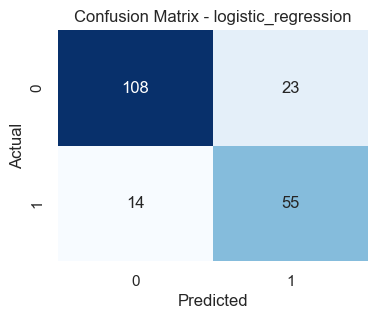

In [ ]:
results = {}

for model_name, model in baseline_models.items():
    with mlflow.start_run(run_name=f'{model_name}_baseline'):
        metrics, y_pred = evaluate_predictions(model, X_test, y_test)
        results[model_name] = metrics

        mlflow.log_param('model_type', model_name)
        mlflow.log_param('variant', 'baseline')
        for k, v in metrics.items():
            mlflow.log_metric(k.lower().replace('-', '_'), float(v))

        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'Confusion Matrix - {model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        cm_path = PROJECT_ROOT / 'reports/figures' / f'cm_{model_name}_baseline.png'
        fig.savefig(cm_path, dpi=150, bbox_inches='tight')
        plt.close(fig)

        mlflow.log_artifact(str(cm_path))
        mlflow.sklearn.log_model(model, artifact_path='model')

        model_path = PROJECT_ROOT / 'models' / f'{model_name}.pkl'
        save_model(model, model_path)

comparison_df = pd.DataFrame(results).T.sort_values(['Recall', 'F1-Score'], ascending=False)
comparison_df

## 6. Hyperparameter Tuning

In [19]:
best_rf, best_rf_params, best_rf_cv = tune_random_forest(X_train, y_train, preprocessor, cv=5)
print('Best RF params:', best_rf_params)
print('Best RF CV recall:', round(best_rf_cv, 4))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best RF params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best RF CV recall: 0.7891


In [20]:
best_xgb, best_xgb_params, best_xgb_cv = tune_xgboost(X_train, y_train, preprocessor, cv=5)
print('Best XGB params:', best_xgb_params)
print('Best XGB CV recall:', round(best_xgb_cv, 4))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGB params: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.03, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best XGB CV recall: 0.7527


## 7. Track Tuned Models in MLflow

In [ ]:
tuned_models = {
    'random_forest_tuned': (best_rf, best_rf_params, best_rf_cv),
    'xgboost_tuned': (best_xgb, best_xgb_params, best_xgb_cv),
}

for model_name, (model, best_params, cv_recall) in tuned_models.items():
    with mlflow.start_run(run_name=model_name):
        metrics, y_pred = evaluate_predictions(model, X_test, y_test)
        results[model_name] = metrics

        mlflow.log_param('model_type', model_name)
        mlflow.log_param('variant', 'tuned')
        mlflow.log_param('cv_folds', 5)
        mlflow.log_metric('cv_best_recall', float(cv_recall))
        mlflow.log_params({k: str(v) for k, v in best_params.items()})

        for k, v in metrics.items():
            mlflow.log_metric(k.lower().replace('-', '_'), float(v))

        cm = confusion_matrix(y_test, y_pred)
        fig, ax = plt.subplots(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax)
        ax.set_title(f'Confusion Matrix - {model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

        cm_path = PROJECT_ROOT / 'reports/figures' / f'cm_{model_name}.png'
        fig.savefig(cm_path, dpi=150, bbox_inches='tight')
        plt.close(fig)

        mlflow.log_artifact(str(cm_path))
        mlflow.sklearn.log_model(model, artifact_path='model')

        save_model(model, PROJECT_ROOT / 'models' / f'{model_name}.pkl')

## 8. Final Model Comparison and Export

In [ ]:
comparison_df = pd.DataFrame(results).T.sort_values(['Recall', 'F1-Score'], ascending=False)
comparison_df.to_csv(PROJECT_ROOT / 'reports/model_comparison_metrics.csv', index=True)
comparison_df

## 9. Notes

- Tuning objective uses recall to align with business need of catching default (`bad`) cases.
- Baseline and tuned models are both persisted in `models/`.
- All experiments, parameters, metrics, confusion matrix artifacts, and model binaries are logged in MLflow.